In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from autorocks.data.loader.all_models_result_aggregator import create_all_models_comparison_dataset
from autorocks.dir_struct import PackageRootDir
from sysgym.envs.rocksdb import schema

param_space = schema.RocksDB10Params()

all_model_df = create_all_models_comparison_dataset(PackageRootDir / "ProcessedDataNew/rocksdb/iops/zippy_workload_15min/10_params/50_iter", save_results=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/salabed/workspace/autorocks/ProcessedDataNew/rocksdb/iops/zippy_workload_15min/10_params/50_iter'

In [ ]:
import pandas as pd
import regex as re

combined_df = pd.merge(all_model_df.sys_params, all_model_df.sys_observations, on=["model", "iteration", "step"]).drop(columns=["model", "iteration", "step", "db_bench.mixgraph.name"])
combined_df.rename(columns=lambda x: re.sub(r'^db_bench\.mixgraph\.', '', x), inplace=True)
combined_df.rename(columns=lambda x: re.sub('rocksdb_?', '', x), inplace=True)
combined_df.rename(columns=lambda x: re.sub(r'_statistics', '', x), inplace=True)
combined_df.rename(columns=lambda x: re.sub(r'_stats', '', x), inplace=True)
combined_df.rename(columns=lambda x: re.sub(r'^statistics.', '', x), inplace=True)
combined_df

In [ ]:
intermediate_col = set(combined_df.columns) - set(param_space) -{"iops", "exe_time", "cpu_usage.count", "cpu_usage.p100", "cpu_usage.p99",
                                                                 "cpu_usage.p95", "cpu_usage.p90", "cpu_usage.p50",
"cpu_usage.sum",
                                                                 "mem_usage.count", "mem_usage.p100", "mem_usage.p99",
                                                                 "mem_usage.p95", "mem_usage.p90", "mem_usage.p50",
                                                                 "mem_usage.sum",
                                                                 }
intermediate_df = combined_df[list(intermediate_col)]
# Remove string
intermediate_df = intermediate_df[intermediate_df.T[intermediate_df.dtypes != object].index]
intermediate_df

In [ ]:
list(param_space)

In [ ]:


from autorocks.optimizer.bograph import preprocessor
from autorocks.optimizer.bograph.dag_preprocessor import PreprocessingPipeline
from autorocks.optimizer.bograph.bograph_dao import BoGraphDataPandas

data = BoGraphDataPandas(params=combined_df[list(param_space)].copy(), objs=combined_df["iops"].copy(), intermediate=intermediate_df.copy())

dp = PreprocessingPipeline(
    preprocessors=[
        # Add average for count
        preprocessor.GrouperProcessor(-2, preprocessor.Compressor.COMBINER),
        # If there are any with useful statistics get it.
        preprocessor.FilterProcessor(-2 ),
        preprocessor.VarianceThresholdPreprocessor(),
        preprocessor.MetricsStandardizerProcessor(standardize_params=False),
        preprocessor.ParamNormalizerProcessor(param_space.bounds().T),
    ]
)

processed_data = dp.fit_transform(data)
sorted(processed_data.intermediate.columns)


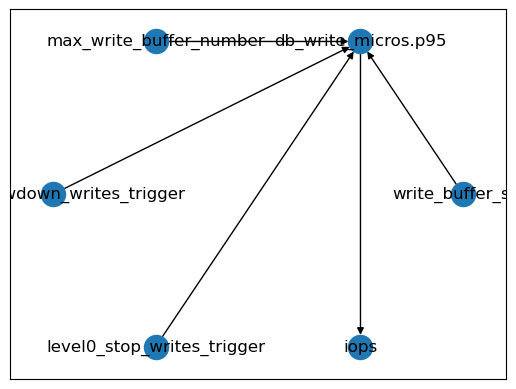

In [3]:
import networkx as nx

g_bard = nx.DiGraph()

g_bard.add_edges_from([
    ('write_buffer_size', 'db_write_micros.p95'),
    ('max_write_buffer_number', 'db_write_micros.p95'),
    ('level0_slowdown_writes_trigger', 'db_write_micros.p95'),
    ('level0_stop_writes_trigger', 'db_write_micros.p95'),
    ('db_write_micros.p95', 'iops'),
    # 
    # ('write_buffer_size', 'db_flush_micros.p95'),
    # ('db_flush_micros.p95', 'iops'),
    # 
    # ('max_background_compactions', 'compaction_times_micros.p95'),
    # ('level0_file_num_compaction_trigger', 'compaction_times_micros.p95'),
    # ('block_size', 'compaction_times_micros.p95'),
    # ('compaction_times_micros.p95', "iops"),
    # 
    # ('block_size', 'write_raw_block_micros.p95'),
    # ('write_raw_block_micros.p95', "iops"),
    # 
    # ('write_buffer_size', 'io_size'),
    # ('block_size', 'io_size'),
    # ('io_size', "iops")
]
)

nx.draw_networkx(g_bard, pos=nx.circular_layout(g_bard))


In [4]:
list(param_space)

['max_background_compactions',
 'max_background_flushes',
 'write_buffer_size',
 'max_write_buffer_number',
 'min_write_buffer_number_to_merge',
 'max_bytes_for_level_multiplier',
 'block_size',
 'level0_file_num_compaction_trigger',
 'level0_slowdown_writes_trigger',
 'level0_stop_writes_trigger']

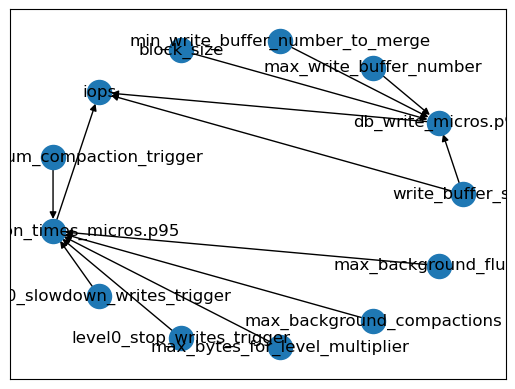

In [5]:
import networkx as nx

expert = nx.DiGraph()

expert.add_edges_from([
    ('write_buffer_size', 'db_write_micros.p95'),
    ('max_write_buffer_number', 'db_write_micros.p95'),
    ('min_write_buffer_number_to_merge', 'db_write_micros.p95'),
    ('block_size', 'db_write_micros.p95'),
    ('db_write_micros.p95', 'iops'),

    ('level0_file_num_compaction_trigger', 'compaction_times_micros.p95'),
    ('level0_slowdown_writes_trigger', 'compaction_times_micros.p95'),
    ('level0_stop_writes_trigger', 'compaction_times_micros.p95'),
    ('max_bytes_for_level_multiplier', 'compaction_times_micros.p95'),
    ('max_background_compactions', 'compaction_times_micros.p95'),
    ('max_background_flushes', 'compaction_times_micros.p95'),
    ('compaction_times_micros.p95', "iops"),

    ('write_buffer_size', 'iops'),
]
)

nx.draw_networkx(expert, pos=nx.circular_layout(expert))


In [6]:
nx.write_gpickle(expert, "rocksdb_fig_10param.gpickle")

Manually connecting param:  {'max_background_flushes', 'block_size', 'level0_file_num_compaction_trigger', 'max_background_compactions', 'max_bytes_for_level_multiplier', 'min_write_buffer_number_to_merge'}


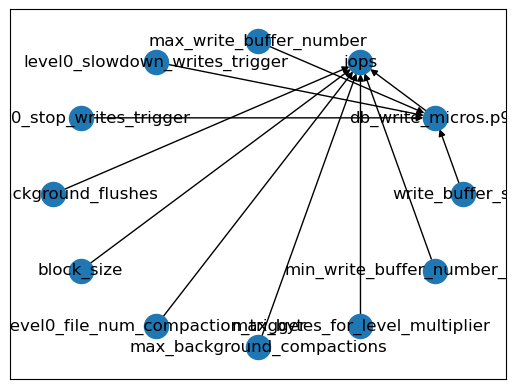

In [7]:
from autorocks.optimizer.bograph.dag_postprocessor import postprocess_structure

g_bard_processed = postprocess_structure(g_bard, set(param_space), {"iops"})
nx.draw_networkx(g_bard_processed, pos=nx.circular_layout(g_bard_processed))


In [8]:
unstructured_dag = nx.DiGraph()
unstructured_dag.add_edges_from([(p, "iops") for p in list(param_space)])    


In [9]:

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [10]:
from autorocks.optimizer.bograph.bobn import BoBn

bobn_model = BoBn(expert, param_space, {"iops"}, False)

INFO:root:Creating a subgraph for the group: {'write_buffer_size'}
INFO:root:Creating a subgraph for the group: {'max_background_flushes', 'level0_file_num_compaction_trigger', 'max_background_compactions', 'max_bytes_for_level_multiplier', 'level0_slowdown_writes_trigger', 'level0_stop_writes_trigger', 'compaction_times_micros.p95'}
INFO:root:Creating a subgraph for the group: {'block_size', 'max_write_buffer_number', 'db_write_micros.p95', 'min_write_buffer_number_to_merge'}
INFO:root:Independent subgraph {'write_buffer_size', 'iops'}, with a max dimension and node: ('iops', 1)
INFO:root:Independent subgraph {'max_background_flushes', 'level0_file_num_compaction_trigger', 'max_background_compactions', 'max_bytes_for_level_multiplier', 'level0_slowdown_writes_trigger', 'iops', 'level0_stop_writes_trigger', 'compaction_times_micros.p95'}, with a max dimension and node: ('compaction_times_micros.p95', 6)
INFO:root:Independent subgraph {'block_size', 'max_write_buffer_number', 'db_write_

In [11]:
res = bobn_model.generate_initial_points(3)
res

[{'write_buffer_size': 154928301,
  'max_background_flushes': 6,
  'level0_file_num_compaction_trigger': 47,
  'max_background_compactions': 3,
  'max_bytes_for_level_multiplier': 10,
  'level0_slowdown_writes_trigger': 61,
  'level0_stop_writes_trigger': 20,
  'block_size': 19738,
  'max_write_buffer_number': 80,
  'min_write_buffer_number_to_merge': 19},
 {'write_buffer_size': 928650040,
  'max_background_flushes': 1,
  'level0_file_num_compaction_trigger': 25,
  'max_background_compactions': 4,
  'max_bytes_for_level_multiplier': 13,
  'level0_slowdown_writes_trigger': 20,
  'level0_stop_writes_trigger': 62,
  'block_size': 123610,
  'max_write_buffer_number': 54,
  'min_write_buffer_number_to_merge': 6},
 {'write_buffer_size': 627923489,
  'max_background_flushes': 5,
  'level0_file_num_compaction_trigger': 55,
  'max_background_compactions': 2,
  'max_bytes_for_level_multiplier': 7,
  'level0_slowdown_writes_trigger': 7,
  'level0_stop_writes_trigger': 45,
  'block_size': 77739,
 

In [12]:

import torch
pd.json_normalize(res)['write_buffer_size']

NameError: name 'pd' is not defined

In [13]:
# MAIN exper
import torch
import baselines
import time
from botorch.utils.transforms import normalize, standardize

from gpytorch.metrics import metrics
from sklearn.model_selection import train_test_split

from typing import NamedTuple


class ExperimentResult(NamedTuple):
    model: str
    restart: int
    step: int
    score: float
    runtime: float
    
    def __str__(self):
        return f"[M: {self.model}, R:{self.restart}, S:{self.step}]: score={self.score}, runtime={self.runtime}]"
    
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
train_size = 50
num_restarts = 1

bounds = torch.from_numpy(param_space.bounds()).T
structured_results = []

data_copy = data.to_combi_pandas().copy(True)
data_deprocessed = dp.inverse_transform(processed_data)
X_FULL = data_deprocessed.param_intermediates_df()
Y_FULL = data_deprocessed.objs


for restart, seed in enumerate([42]):
    X_train, X_test, y_train, y_test  = train_test_split(X_FULL, Y_FULL, train_size = train_size, random_state=seed)
    observations = pd.merge(X_train, y_train, left_index = True, right_index = True).reset_index(drop=True)

    X_test =  normalize(torch.tensor(X_test[list(param_space)].values), bounds).to(**tkwargs)
    y_test = standardize(torch.tensor(y_test.values)).to(**tkwargs)

    for model_name in ["structured"]:

        for step in range(30, train_size):
            start_time = time.time()
            model  = baselines.run_model(bobn_model, observations = observations[:step])
            elapsed_time = time.time() - start_time

            score = float(metrics.negative_log_predictive_density(model(X_test).mvn, y_test))
            result = ExperimentResult(model = model_name, restart = restart, step = step, score = score, runtime = elapsed_time)
            structured_results.append(result)
            print(f"{result=}")


NameError: name 'data' is not defined